# Devoir 1 - Compréhension et préparation des données d’apprentissage

#### Chargement des librairies

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import pycountry

#### Chargement des datasets

In [2]:
# Chargement des données
customer_df = pd.read_csv("Customer.csv")
gdp_df = pd.read_csv("CountryGDP.csv")
pop_df = pd.read_csv("CountryPopulation.csv")

## Etape 2 : Évaluation de la faisabilité des solutions proposées

In [3]:
# Exploration des données
print(customer_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               10000 non-null  float64
 1   pages             10000 non-null  float64
 2   first_item_prize  10000 non-null  object 
 3   gender            10000 non-null  object 
 4   ReBuy             10000 non-null  bool   
 5   News_click        10000 non-null  float64
 6   country           10000 non-null  object 
 7   revenue           10000 non-null  object 
dtypes: bool(1), float64(3), object(4)
memory usage: 556.8+ KB
None


In [4]:
print(customer_df.describe(include='all'))

                 age         pages first_item_prize gender  ReBuy  \
count   10000.000000  10000.000000            10000  10000  10000   
unique           NaN           NaN               11      2      2   
top              NaN           NaN             44.0    Fem  False   
freq             NaN           NaN             2083   6902   7200   
mean       37.431400      5.995000              NaN    NaN    NaN   
std         9.490474      2.438559              NaN    NaN    NaN   
min        18.000000      1.000000              NaN    NaN    NaN   
25%        31.000000      5.000000              NaN    NaN    NaN   
50%        37.000000      6.000000              NaN    NaN    NaN   
75%        43.000000      7.000000              NaN    NaN    NaN   
max        79.000000     14.000000              NaN    NaN    NaN   

          News_click country revenue  
count   10000.000000   10000   10000  
unique           NaN      50     469  
top              NaN   China      68  
freq           

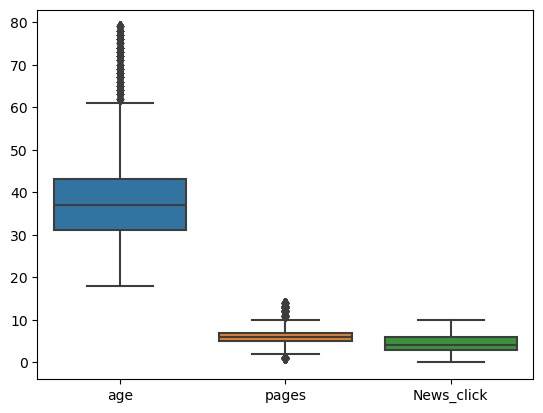

In [5]:
# Visualisation des outliers
sns.boxplot(data=customer_df.select_dtypes(include=["number"]))
plt.show()

## Etape 3 : Exploration des données - ´Problèmes récurrent : données manquante, aberrant et –outliers

Conversion des colonnes en numérique avant l'imputation
def convert_to_numeric(df):
    for col in df.columns:
        if df[col].dtype == "object":
            try:
                df[col] = pd.to_numeric(df[col], errors='coerce')
            except ValueError:
                pass
    return df

In [6]:
# Nettoyage des valeurs manquantes
def clean_missing_values(df):
    df = df.copy()
    df.replace(["unknown", "?"], np.nan, inplace=True)

    # Imputation des valeurs catégoriques
    object_cols = df.select_dtypes(include=["object"]).columns
    if len(object_cols) > 0:
        imputer_cat = SimpleImputer(strategy='most_frequent')
        df[object_cols] = imputer_cat.fit_transform(df[object_cols])

    # Conversion en numérique
    for col in df.columns:
        if df[col].dtype == "object" and col != "gender":  # Exclure 'gender'
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Imputation des valeurs numériques
    numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()
    df_numeric = df[numeric_cols].copy()

    # Encoder 'gender' après imputation :
    df["gender"] = df["gender"].map({"Fem": 0, "Masc": 1}).astype("float")
    
    # Exclure les colonnes contenant uniquement des NaN
    non_empty_cols = df_numeric.columns[df_numeric.notna().any()].tolist()
    df_numeric = df_numeric[non_empty_cols]

    if not df_numeric.empty:
        imputer_num = SimpleImputer(strategy='median')
        df_imputed = pd.DataFrame(
            imputer_num.fit_transform(df_numeric),
            columns=non_empty_cols,
            index=df.index
        )
        df.update(df_imputed)

    return df

In [7]:
# Détection et traitement des outliers
def treat_outliers(df):
    for col in df.select_dtypes(include=["number"]):
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = np.where(df[col] < lower_bound, Q1, df[col])
        df[col] = np.where(df[col] > upper_bound, Q3, df[col])
    return df

#### Pipeline pour les dataset "Customer"

In [8]:
# Création de la classe de transformation
class CustomerPreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = clean_missing_values(X)
        X = treat_outliers(X)
        return X

In [9]:
# Pipeline de prétraitement des données clients
customer_pipeline = Pipeline([
    ("preprocessor", CustomerPreprocessor())
])

## Enrichissement
#### Prétraitement des datasets pour l'enrichissement des données

In [10]:
# Nettoyage et fusion des datasets externes
def merge_datasets(customer_df, gdp_df, pop_df, include_gdp=True):
    # Renommer les colonnes pour assurer une fusion correcte
    pop_df = pop_df.rename(columns={"Country": "country"})
    gdp_df = gdp_df.rename(columns={"Country": "country"})

    # Fusionner les datasets sur "country"
    merged_df = customer_df.merge(pop_df, on="country", how="left")
    if include_gdp:
        merged_df = merged_df.merge(gdp_df, on="country", how="left")
    
    return merged_df

In [11]:
# Conception de la Table de Base Analytique (TBA)
def create_tba(df):
    df["GDP_per_capita"] = df["GDP"] / df["population"]
    return df

In [12]:
class DataEnrichmentTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, pop_df, gdp_df):
        # Renommage explicite des colonnes
        self.pop_df = pop_df.rename(columns={"Country": "country"})
        self.gdp_df = gdp_df.rename(columns={"Country": "country"})
        
        # Mapping manuel étendu
        self.country_mapping = {
            'usa': 'united states',
            'us': 'united states',
            'uk': 'united kingdom',
            'russia': 'russian federation',
            'congo': 'congo, democratic republic of the',
            'brunei': 'brunei darussalam'
        }

    def _normalize_country(self, name):
        """Normalisation robuste des noms de pays"""
        try:
            name = str(name).strip().lower()
            name = self.country_mapping.get(name, name)
            return pycountry.countries.search_fuzzy(name)[0].name.lower()
        except:
            return np.nan

    def fit(self, X, y=None):
        # Préparation des données externes
        self.pop_df_clean = self.pop_df.copy()
        self.pop_df_clean["country"] = self.pop_df_clean["country"].apply(self._normalize_country)
        
        self.gdp_df_clean = self.gdp_df.copy()
        self.gdp_df_clean["country"] = self.gdp_df_clean["country"].apply(self._normalize_country)
        
        # Calcul des valeurs médianes
        self.fallback_population_ = self.pop_df_clean["population"].median()
        self.fallback_gdp_ = self.gdp_df_clean["GDP_inhab"].median()
        
        return self

    def transform(self, X):
        X = X.copy()
        
        # Normalisation du pays client
        X["country"] = X["country"].apply(self._normalize_country)
        
        # Fusion garantie avec vérification
        merged = pd.merge(X, self.pop_df_clean, on="country", how="left")
        merged = pd.merge(merged, self.gdp_df_clean, on="country", how="left")
        
        # Imputation finale
        merged["population"] = merged["population"].fillna(self.fallback_population_)
        merged["GDP_inhab"] = merged["GDP_inhab"].fillna(self.fallback_gdp_)
        
        return merged.drop(columns=["country"])

In [13]:
# Utilisation ---------------------------------------------------------
# Préparation initiale des données externes
pop_df = pop_df.rename(columns={'Country': 'country', 'Population': 'population'})
gdp_df = gdp_df.rename(columns={'Country': 'country', 'GDP_per_capita': 'GDP_inhab'})

#### Pipeline combiné

In [14]:
# Pipeline final
full_pipeline = Pipeline([
    ('customer_processing', customer_pipeline),
    ('data_enrichment', DataEnrichmentTransformer(pop_df, gdp_df))
])

In [15]:
# Application du pipeline
df_final = full_pipeline.fit_transform(customer_df)

In [16]:
# Vérifier le résultat
print(df_final[['population', 'GDP_inhab']].head())
print("\nValeurs manquantes :")
print(df_final[['population', 'GDP_inhab']].isna().sum())

   population  GDP_inhab
0    65926261       9503
1    65926261       9503
2    65926261       9503
3    65926261       9503
4    65926261       9503

Valeurs manquantes :
population    0
GDP_inhab     0
dtype: int64


In [17]:
# Affichage du résultat
print(df_final.info())
print(df_final.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               10000 non-null  float64
 1   pages             10000 non-null  float64
 2   first_item_prize  10000 non-null  float64
 3   gender            10000 non-null  float64
 4   ReBuy             10000 non-null  bool   
 5   News_click        10000 non-null  float64
 6   revenue           10000 non-null  float64
 7   population        10000 non-null  int64  
 8   GDP_inhab         10000 non-null  int64  
dtypes: bool(1), float64(6), int64(2)
memory usage: 634.9 KB
None
    age  pages  first_item_prize  gender  ReBuy  News_click  revenue  \
0  41.0    6.0              28.0     0.0  False         4.0    113.0   
1  34.0    4.0              15.5     0.0   True         2.0     36.0   
2  38.0    5.0              44.0     0.0  False         7.0    111.0   
3  20.0    5.0        

In [18]:
# Sauvegarde du dataset final
df_final.to_csv("Customer_final.csv", index=False)

print("Prétraitement et enrichissement terminés. Fichier sauvegardé.")

Prétraitement et enrichissement terminés. Fichier sauvegardé.
